In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train=pd.read_csv("/kaggle/input/titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test=pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.shape

(891, 12)

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
def detect_outliers(df, n, features):
    outlier_index=[]
    
    for col in features:
        Q1=np.percentile(df[col], 25)
        Q3=np.percentile(df[col], 75)
        IQR=Q3-Q1
        
        outlier_step=IQR*1.5
        
        outlier_col_list=df[(df[col]<Q1 - outlier_step) | (df[col]>Q3-outlier_step)].index
        
        outlier_index.extend(outlier_col_list)
    
    outlier_index=Counter(outlier_index)
    
    multiple_outliers = list( k for k, v in outlier_index.items() if v > n )
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [8]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


In [9]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [10]:
train["Name_Size"]=train["Name"].apply(lambda x: len(x))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24


In [11]:
def cabin_list(cabin_str):
    l=str(cabin_str).split()
    return l
train["Cabin_List"]=train["Cabin"].apply(cabin_list)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan]
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85]
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan]
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123]
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan]


In [12]:
train["Word_Count"]=train["Name"].apply(lambda x: len(str(x).split()))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List,Word_Count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan],4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85],7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan],3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123],7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan],4


In [13]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan],4,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85],7,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan],3,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123],7,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan],4,0


In [14]:
train["Family_Count"]=train["SibSp"]+train["Parch"]+1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan],4,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85],7,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan],3,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123],7,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan],4,0,1


In [15]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

train["Title"]=train["Name"].apply(get_title)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan],4,0,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85],7,1,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan],3,0,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123],7,1,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan],4,0,1,Mr


In [16]:
train["Is_Alone"]=0
train.loc[train['Family_Count'] == 1, 'Is_Alone'] = 1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan],4,0,2,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85],7,1,2,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan],3,0,1,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123],7,1,2,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan],4,0,1,Mr,1


In [17]:
train["Is_Alone"]=train["Is_Alone"].fillna(0)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan],4,0,2,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85],7,1,2,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan],3,0,1,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123],7,1,2,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan],4,0,1,Mr,1


In [18]:
train["Ticket_Len"]=train["Ticket"].apply(lambda x: len(x))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,[nan],4,0,2,Mr,0,9
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,[C85],7,1,2,Mrs,0,8
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,[nan],3,0,1,Miss,1,16
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,[C123],7,1,2,Mrs,0,6
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,[nan],4,0,1,Mr,1,6


In [19]:
train["Ticket_Word"]=train["Ticket"].apply(lambda x: len(str(x).split()))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,23,[nan],4,0,2,Mr,0,9,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,51,[C85],7,1,2,Mrs,0,8,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,22,[nan],3,0,1,Miss,1,16,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,44,[C123],7,1,2,Mrs,0,6,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,24,[nan],4,0,1,Mr,1,6,1


In [20]:
train["Cabin"]=train["Cabin"].fillna("Na")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,23,[nan],4,0,2,Mr,0,9,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,51,[C85],7,1,2,Mrs,0,8,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,22,[nan],3,0,1,Miss,1,16,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,44,[C123],7,1,2,Mrs,0,6,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,24,[nan],4,0,1,Mr,1,6,1


In [21]:
train["Fare_Sq"]=train["Fare"]**2
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Name_Size,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,23,[nan],4,0,2,Mr,0,9,2,52.562500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,51,[C85],7,1,2,Mrs,0,8,2,5081.308859
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,22,[nan],3,0,1,Miss,1,16,2,62.805625
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,44,[C123],7,1,2,Mrs,0,6,1,2819.610000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,24,[nan],4,0,1,Mr,1,6,1,64.802500


In [22]:
train["Word_Count_Sq"]=train["Word_Count"]**2
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_List,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,[nan],4,0,2,Mr,0,9,2,52.562500,16
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,[C85],7,1,2,Mrs,0,8,2,5081.308859,49
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,[nan],3,0,1,Miss,1,16,2,62.805625,9
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,[C123],7,1,2,Mrs,0,6,1,2819.610000,49
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,[nan],4,0,1,Mr,1,6,1,64.802500,16


In [23]:
train["Name_Size_Sq"]=train["Name_Size"]**2
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,4,0,2,Mr,0,9,2,52.562500,16,529
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,7,1,2,Mrs,0,8,2,5081.308859,49,2601
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,3,0,1,Miss,1,16,2,62.805625,9,484
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,7,1,2,Mrs,0,6,1,2819.610000,49,1936
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,4,0,1,Mr,1,6,1,64.802500,16,576


In [24]:
def num_cabin(cabin_list):
    return len(cabin_list)
train["Cabin_Size"]=train["Cabin_List"].apply(num_cabin)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,2,Mr,0,9,2,52.562500,16,529,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,2,Mrs,0,8,2,5081.308859,49,2601,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,Miss,1,16,2,62.805625,9,484,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,2,Mrs,0,6,1,2819.610000,49,1936,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,Mr,1,6,1,64.802500,16,576,1


In [25]:
sns.set(rc={'figure.figsize':(30,30)})

<AxesSubplot:>

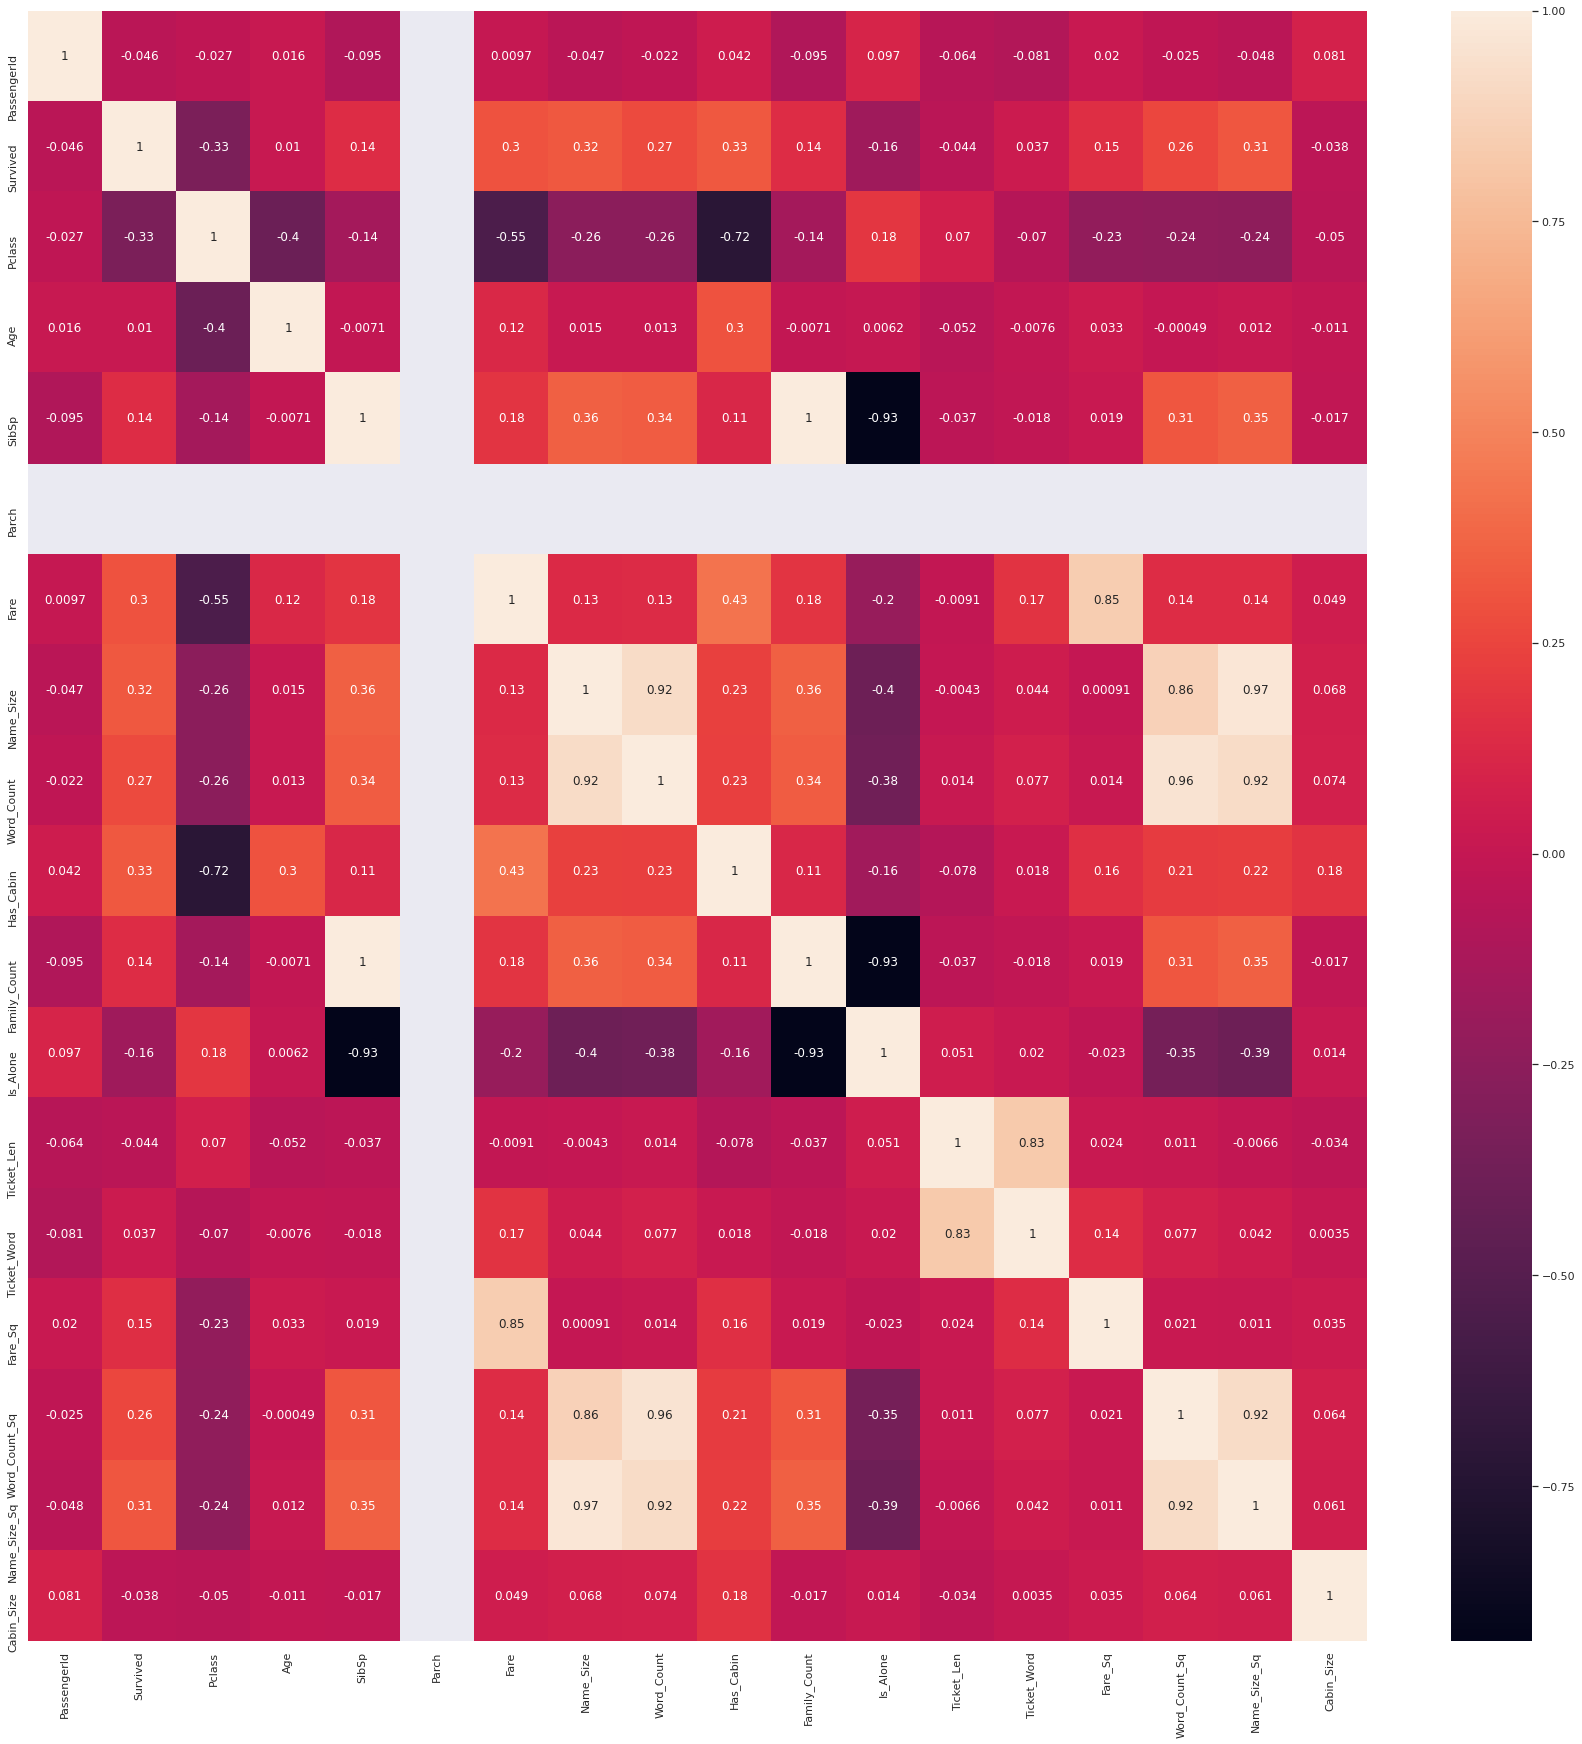

In [26]:
corr=train.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

In [27]:
sns.set(rc={'figure.figsize':(10,10)})

<AxesSubplot:xlabel='Survived', ylabel='count'>

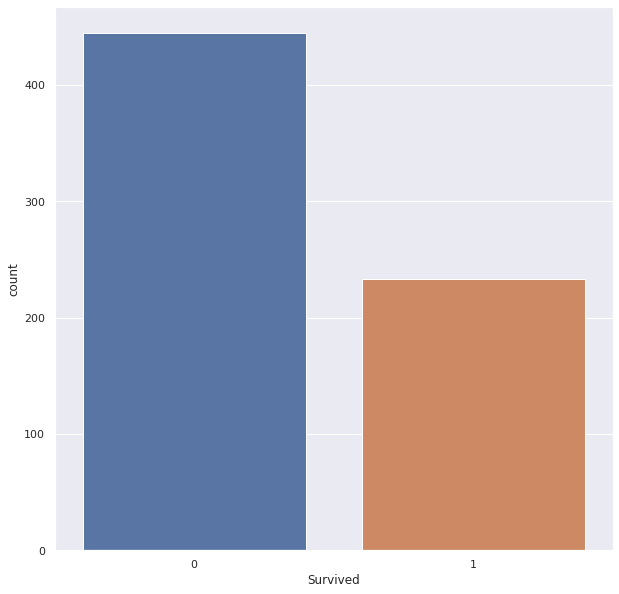

In [28]:
sns.countplot(x="Survived", data=train)

<AxesSubplot:xlabel='Is_Alone', ylabel='count'>

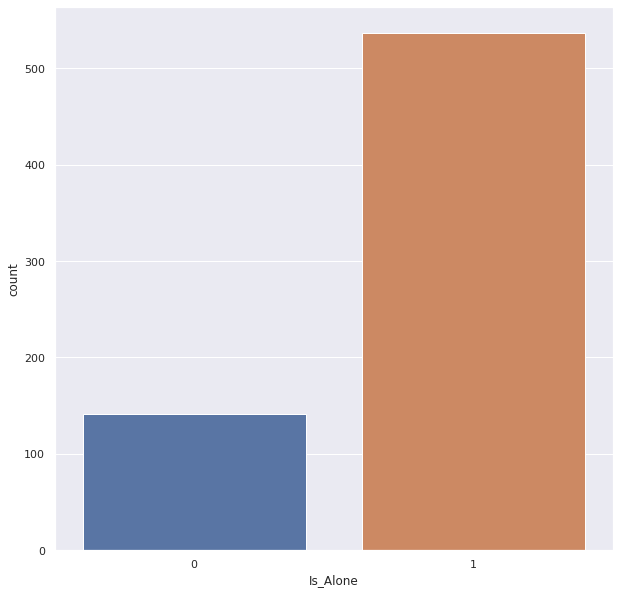

In [29]:
sns.countplot(x="Is_Alone", data=train)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

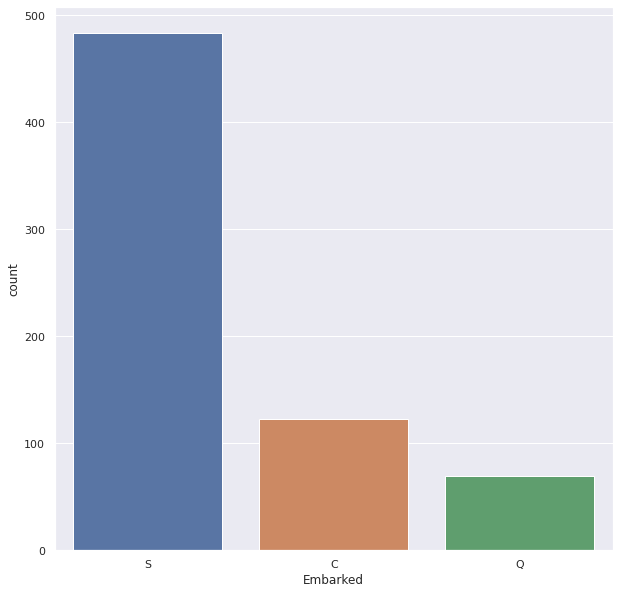

In [30]:
sns.countplot(x="Embarked", data=train)

<AxesSubplot:xlabel='Sex', ylabel='count'>

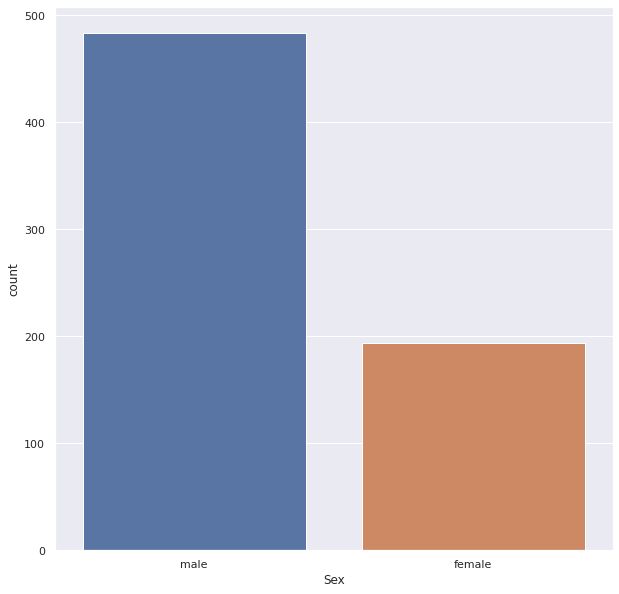

In [31]:
sns.countplot(x="Sex", data=train)

<AxesSubplot:xlabel='Has_Cabin', ylabel='count'>

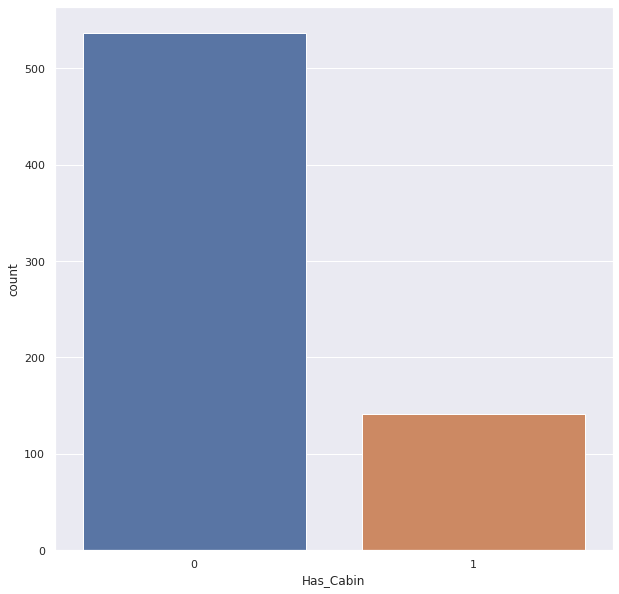

In [32]:
sns.countplot(x="Has_Cabin", data=train)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

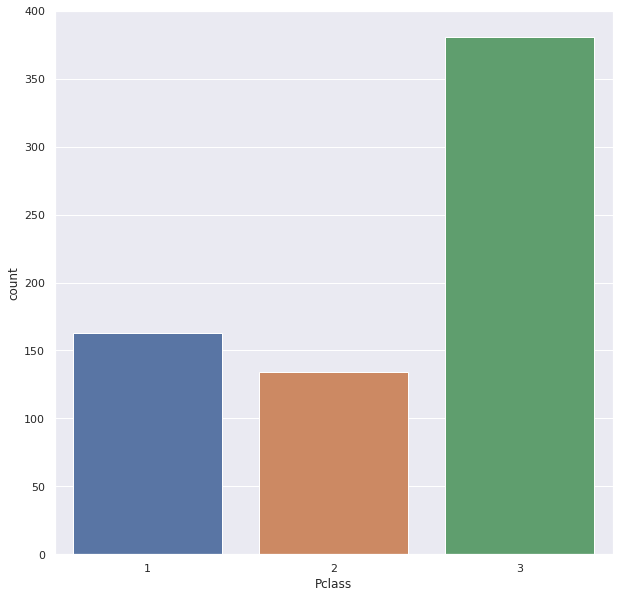

In [33]:
sns.countplot(x="Pclass", data=train)

<AxesSubplot:xlabel='Title', ylabel='count'>

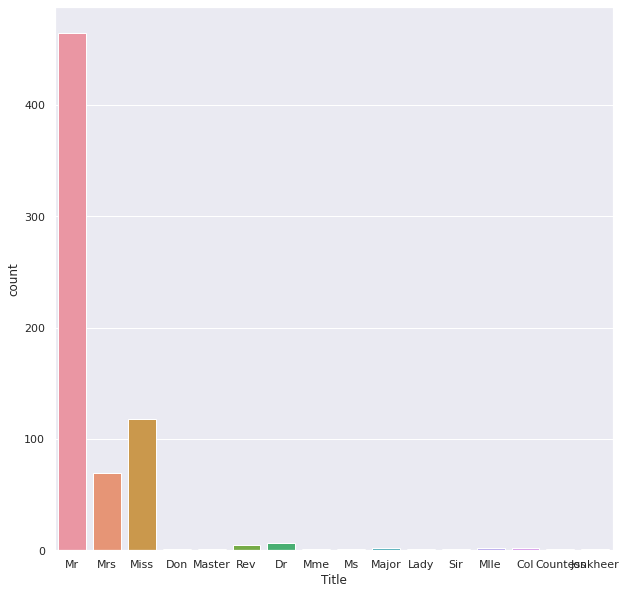

In [34]:
sns.countplot(x="Title", data=train)

<AxesSubplot:xlabel='Word_Count', ylabel='Count'>

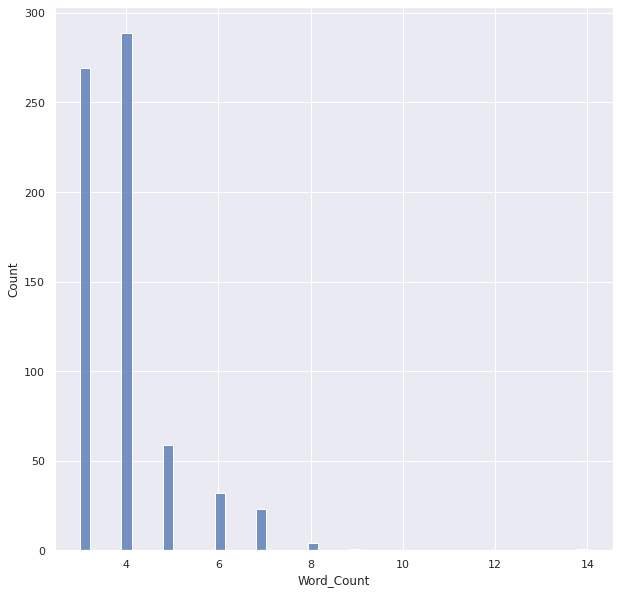

In [35]:
sns.histplot(x="Word_Count", data=train)

<AxesSubplot:xlabel='Name_Size', ylabel='Count'>

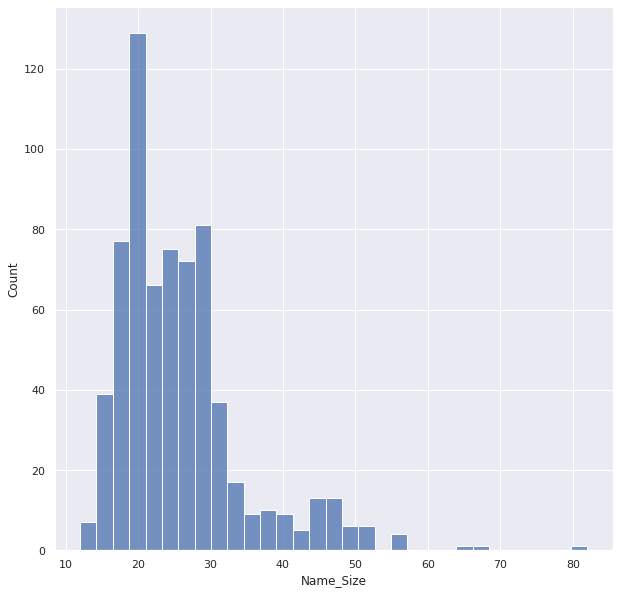

In [36]:
sns.histplot(x="Name_Size", data=train)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

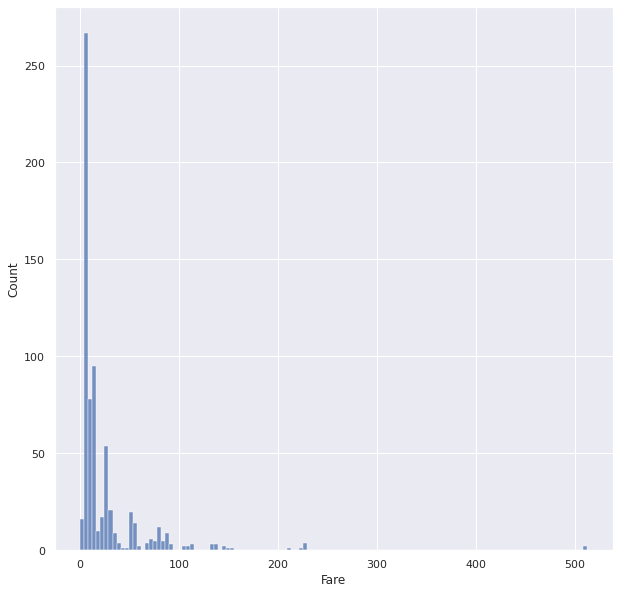

In [37]:
sns.histplot(x="Fare", data=train)

<AxesSubplot:xlabel='Ticket_Len', ylabel='Count'>

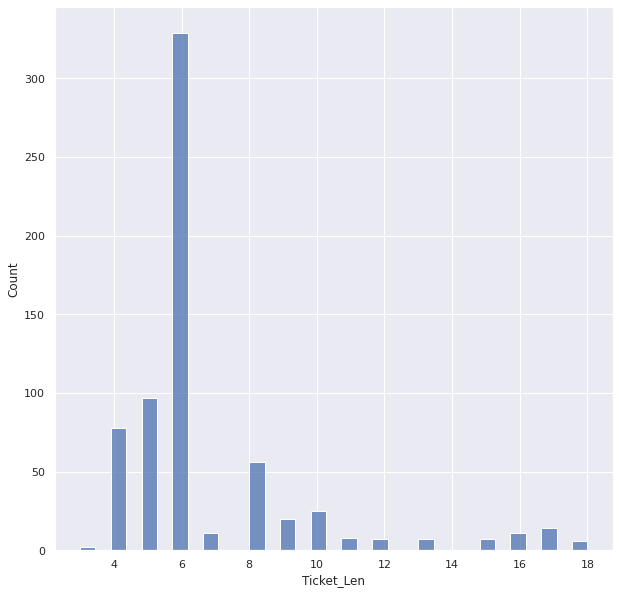

In [38]:
sns.histplot(x="Ticket_Len", data=train)

<AxesSubplot:xlabel='Age', ylabel='Count'>

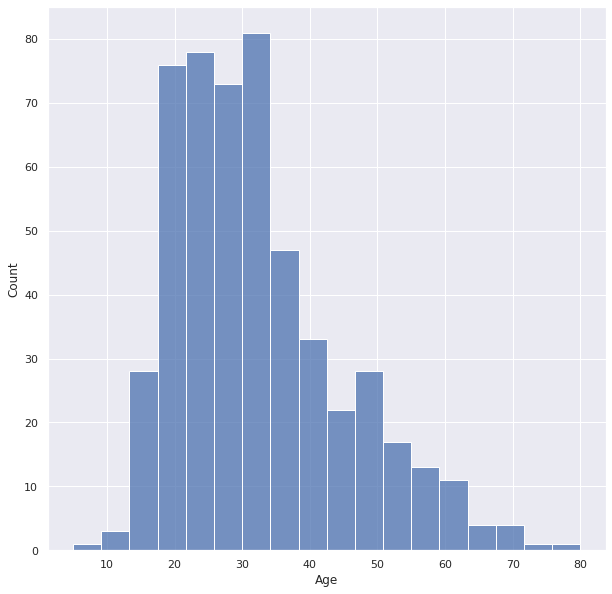

In [39]:
sns.histplot(x="Age", data=train)

<AxesSubplot:xlabel='Ticket_Word', ylabel='Count'>

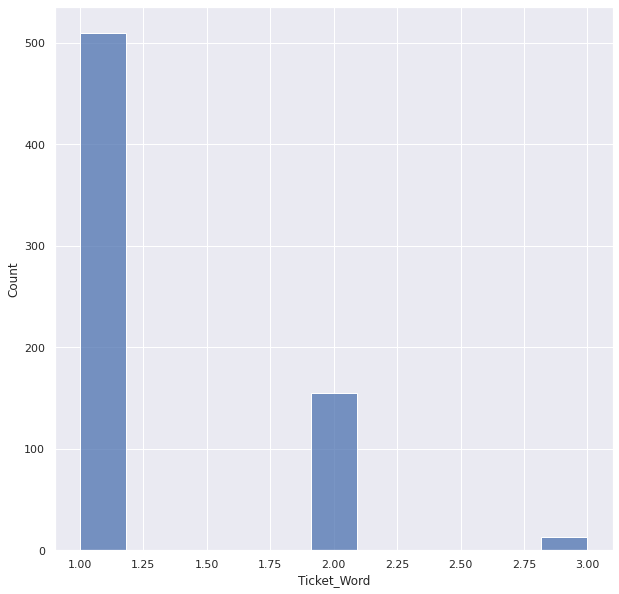

In [40]:
sns.histplot(x="Ticket_Word", data=train)

<AxesSubplot:xlabel='Family_Count', ylabel='Count'>

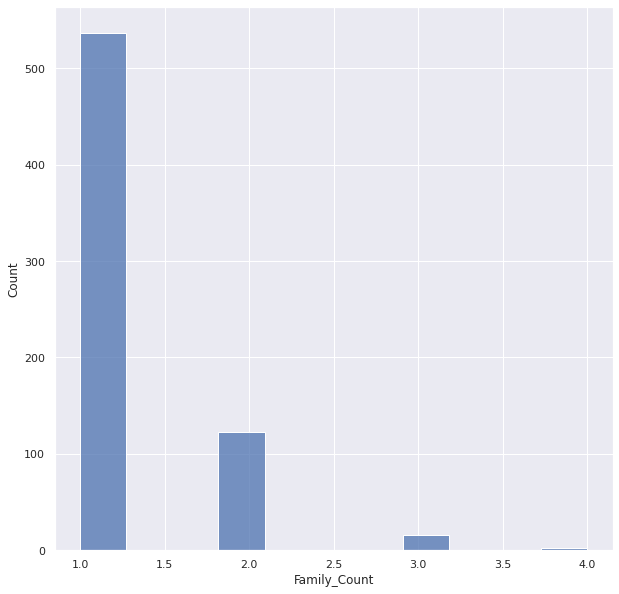

In [41]:
sns.histplot(x="Family_Count", data=train)

<AxesSubplot:xlabel='Cabin_Size', ylabel='Count'>

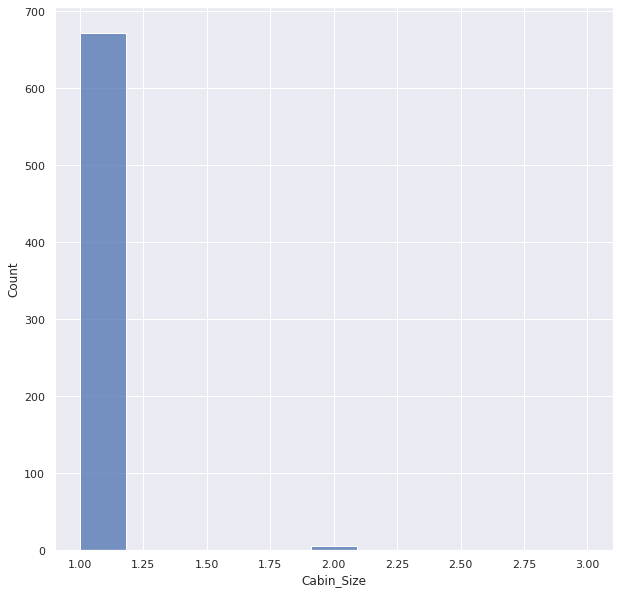

In [42]:
sns.histplot(x="Cabin_Size", data=train)

<AxesSubplot:xlabel='Family_Count', ylabel='Count'>

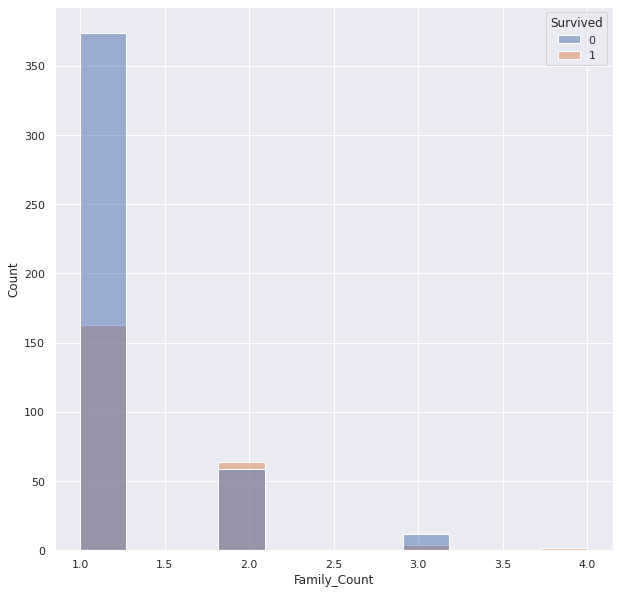

In [43]:
sns.histplot(x="Family_Count", hue="Survived", data=train)

<AxesSubplot:xlabel='Ticket_Word', ylabel='Count'>

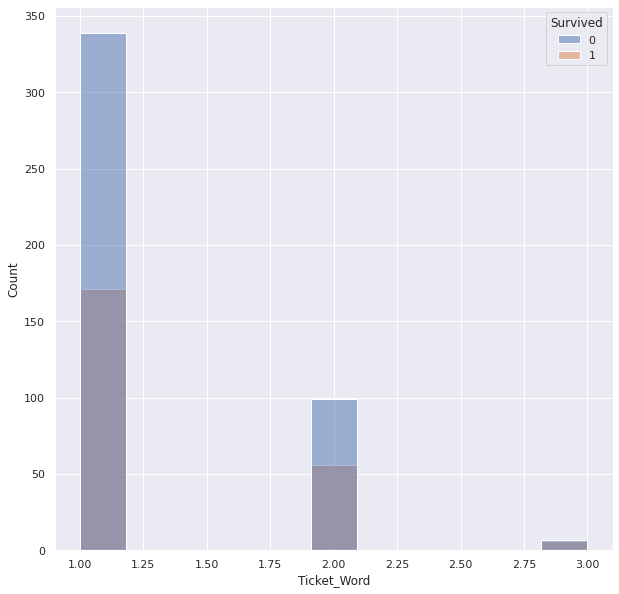

In [44]:
sns.histplot(x="Ticket_Word", hue="Survived", data=train)

<AxesSubplot:xlabel='Ticket_Len', ylabel='Count'>

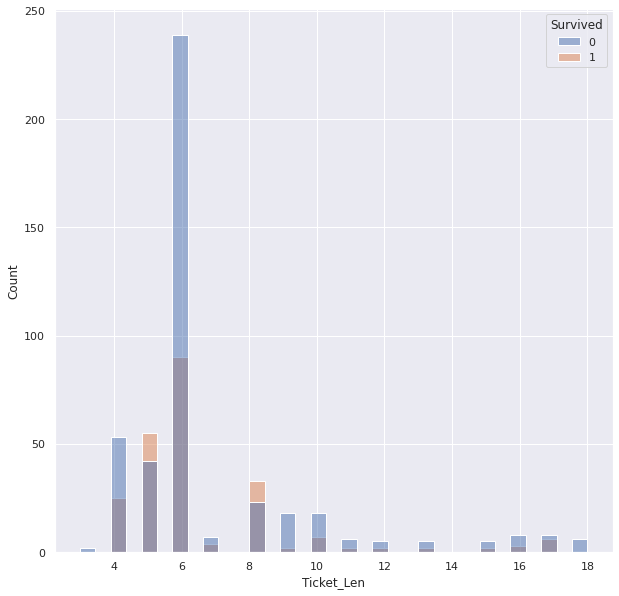

In [45]:
sns.histplot(x="Ticket_Len", hue="Survived", data=train)

<AxesSubplot:xlabel='Age', ylabel='Count'>

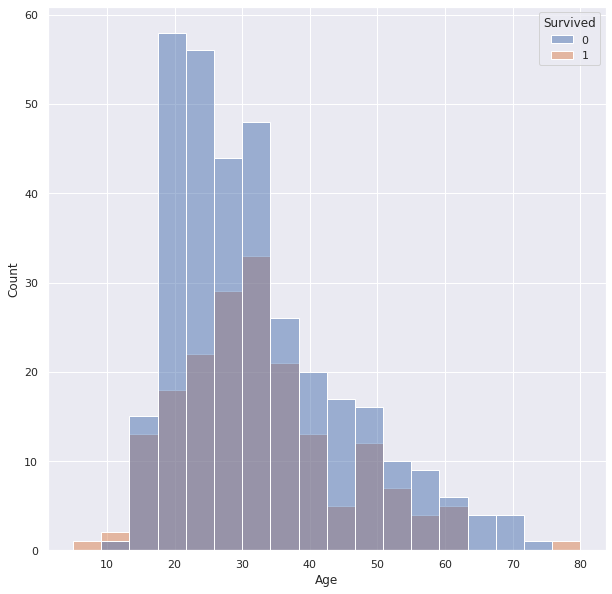

In [46]:
sns.histplot(x="Age", hue="Survived", data=train)

<AxesSubplot:xlabel='Word_Count', ylabel='Count'>

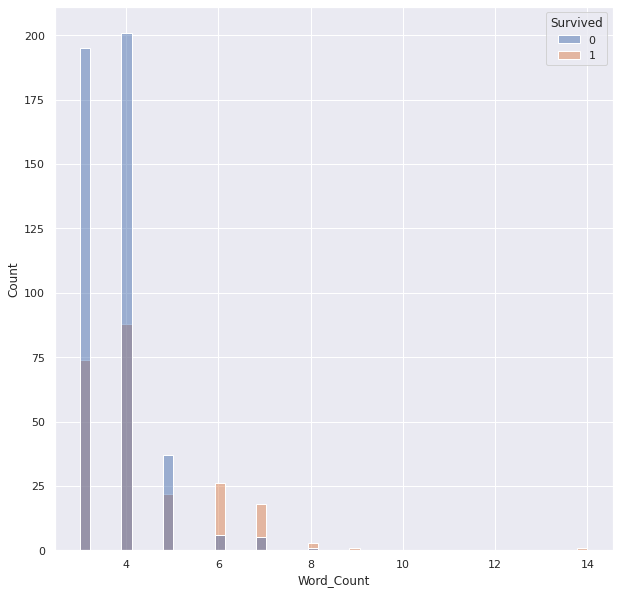

In [47]:
sns.histplot(x="Word_Count", hue="Survived", data=train)

<AxesSubplot:xlabel='Name_Size', ylabel='Count'>

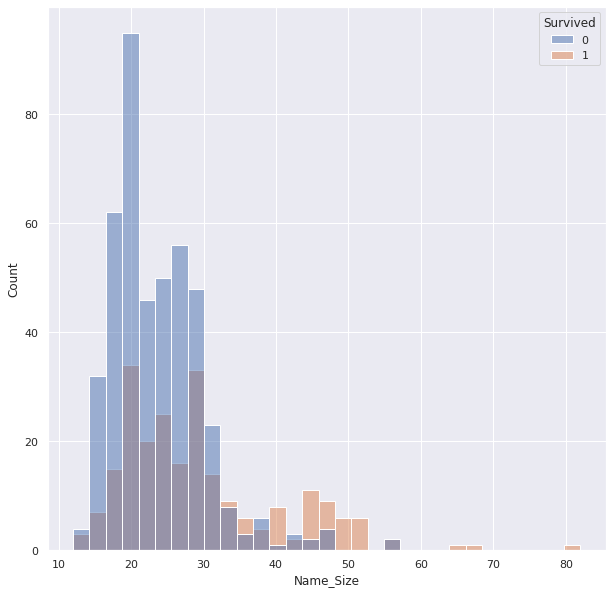

In [48]:
sns.histplot(x="Name_Size", hue="Survived", data=train)

<AxesSubplot:xlabel='PassengerId', ylabel='Count'>

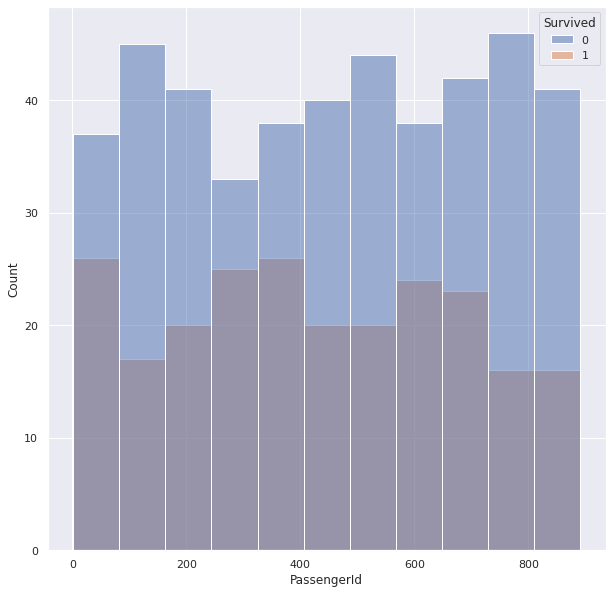

In [49]:
sns.histplot(x="PassengerId", hue="Survived",data=train)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

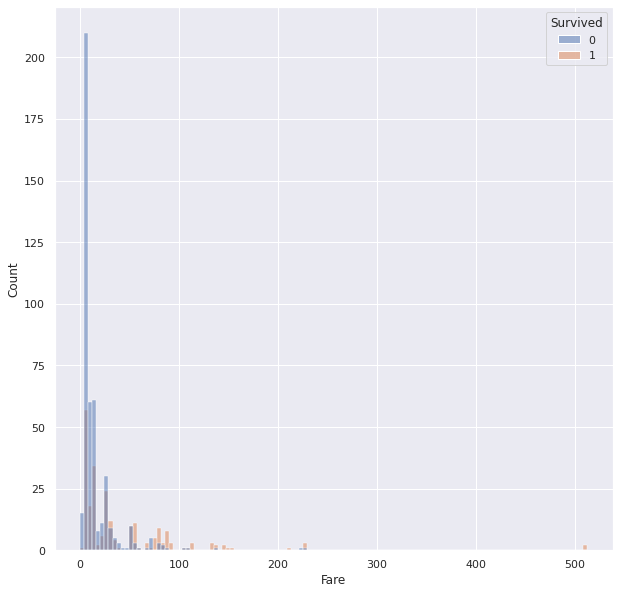

In [50]:
sns.histplot(x="Fare", hue="Survived", data=train)

<AxesSubplot:xlabel='Parch', ylabel='Count'>

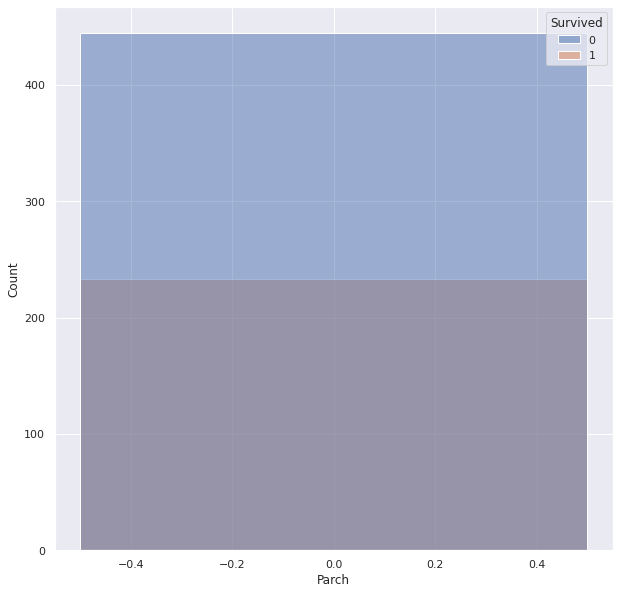

In [51]:
sns.histplot(x="Parch", hue="Survived", data=train)

<AxesSubplot:xlabel='SibSp', ylabel='Count'>

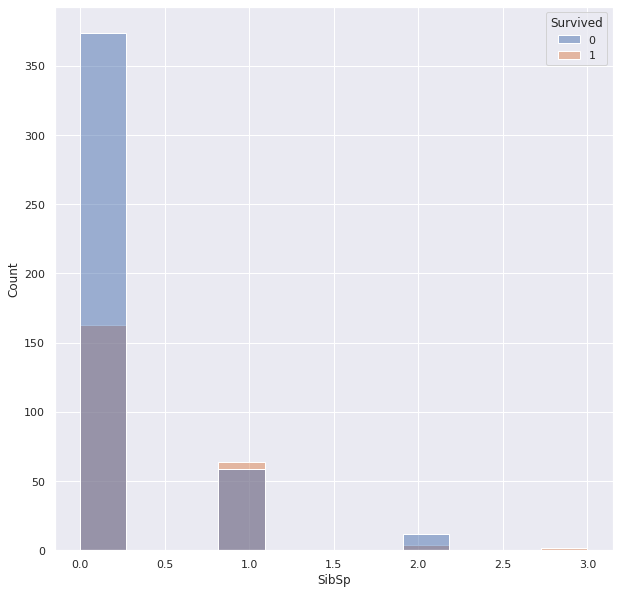

In [52]:
sns.histplot(x="SibSp", hue="Survived", data=train)

<AxesSubplot:xlabel='Survived', ylabel='Title'>

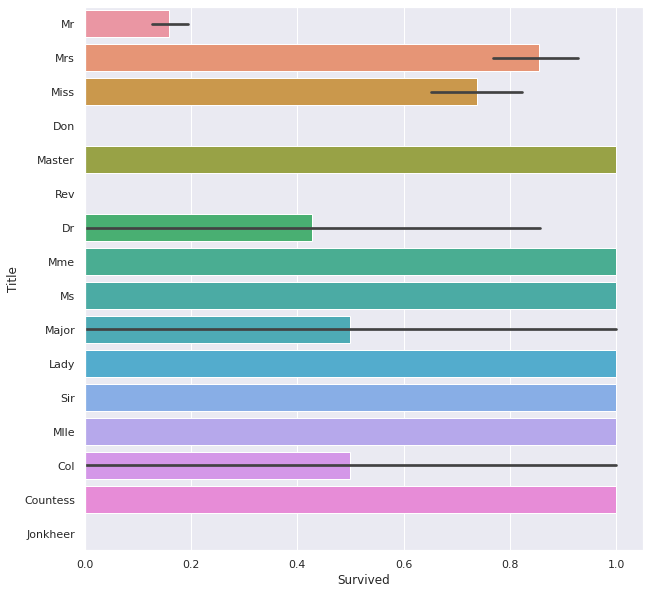

In [53]:
sns.barplot(x="Survived", y="Title", data=train)

<AxesSubplot:xlabel='Survived', ylabel='Is_Alone'>

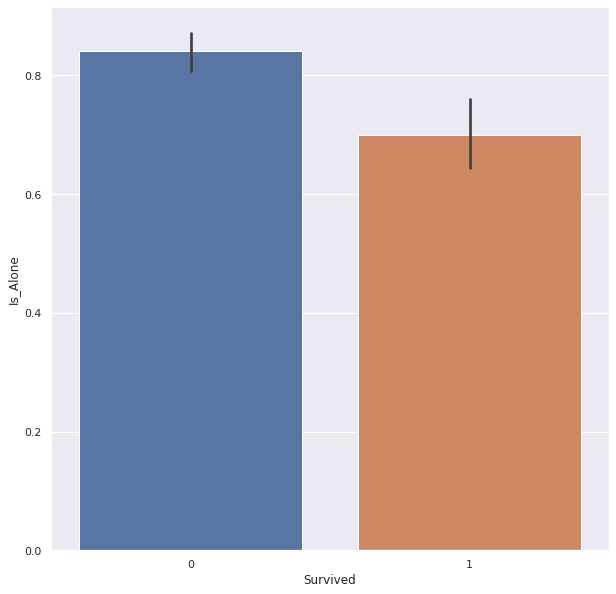

In [54]:
sns.barplot(x="Survived", y="Is_Alone", data=train)

<AxesSubplot:xlabel='Survived', ylabel='Has_Cabin'>

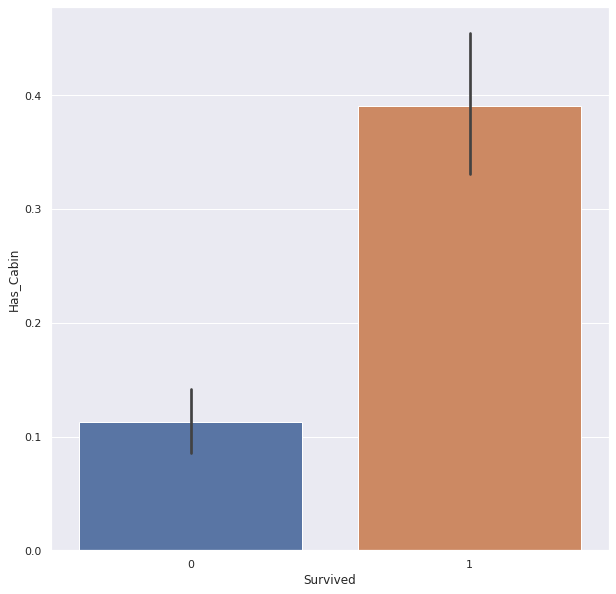

In [55]:
sns.barplot(x="Survived", y="Has_Cabin", data=train)

<AxesSubplot:xlabel='Survived', ylabel='Embarked'>

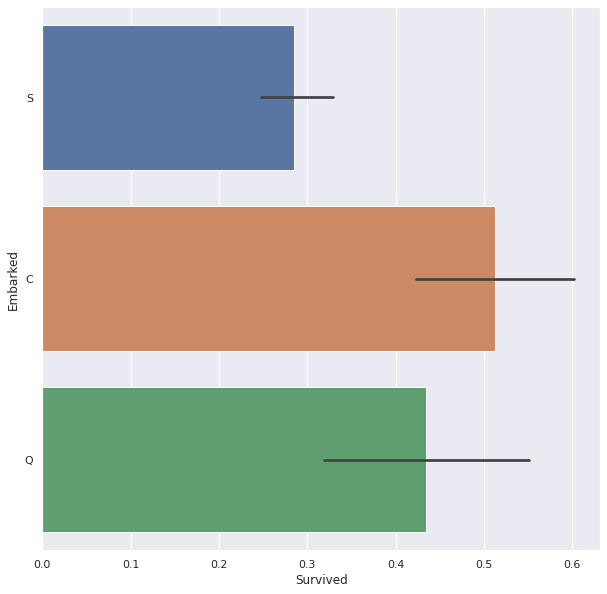

In [56]:
sns.barplot(x="Survived", y="Embarked", data=train)

<AxesSubplot:xlabel='Survived', ylabel='Sex'>

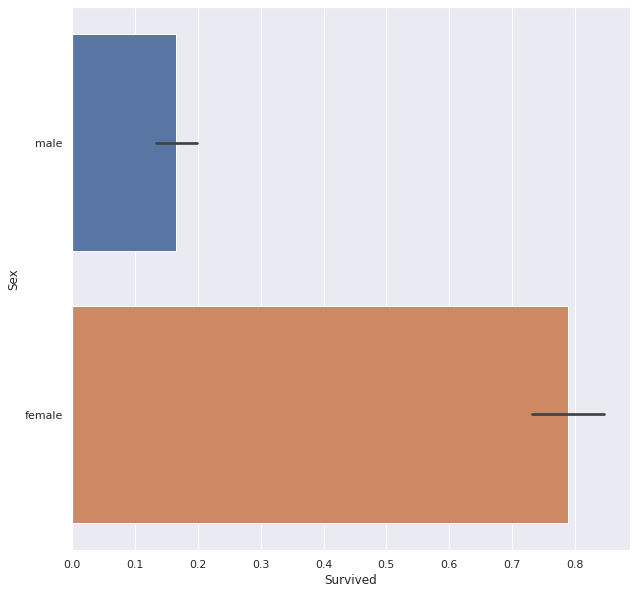

In [57]:
sns.barplot(x="Survived", y="Sex", data=train)

In [58]:
train=train.fillna(train.median())

In [59]:
train["Embarked"]=train["Embarked"].fillna("S")

In [60]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Name_Size        0
Cabin_List       0
Word_Count       0
Has_Cabin        0
Family_Count     0
Title            0
Is_Alone         0
Ticket_Len       0
Ticket_Word      0
Fare_Sq          0
Word_Count_Sq    0
Name_Size_Sq     0
Cabin_Size       0
dtype: int64

<AxesSubplot:xlabel='Cabin_Size', ylabel='Count'>

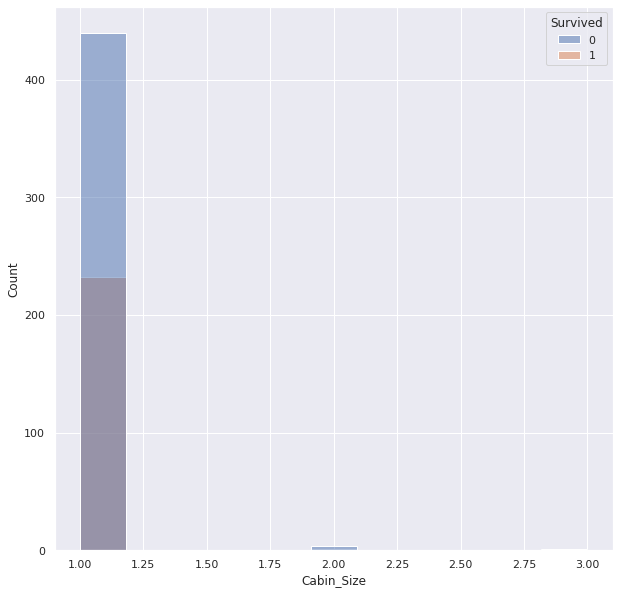

In [61]:
sns.histplot(x="Cabin_Size", hue="Survived", data=train)

In [62]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,2,Mr,0,9,2,52.562500,16,529,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,2,Mrs,0,8,2,5081.308859,49,2601,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,Miss,1,16,2,62.805625,9,484,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,2,Mrs,0,6,1,2819.610000,49,1936,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,Mr,1,6,1,64.802500,16,576,1


In [63]:
train["Gender"]=train["Sex"].map({"male": 0, "female": 1})
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,2,Mr,0,9,2,52.562500,16,529,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,2,Mrs,0,8,2,5081.308859,49,2601,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,Miss,1,16,2,62.805625,9,484,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,2,Mrs,0,6,1,2819.610000,49,1936,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,Mr,1,6,1,64.802500,16,576,1,0


In [64]:
train.drop(["Sex", "PassengerId", "Ticket", "Name", "Cabin","Cabin", "Cabin_List"], axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Name_Size,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size,Gender
0,0,3,22.0,1,0,7.2500,S,23,4,0,2,Mr,0,9,2,52.562500,16,529,1,0
1,1,1,38.0,1,0,71.2833,C,51,7,1,2,Mrs,0,8,2,5081.308859,49,2601,1,1
2,1,3,26.0,0,0,7.9250,S,22,3,0,1,Miss,1,16,2,62.805625,9,484,1,1
3,1,1,35.0,1,0,53.1000,S,44,7,1,2,Mrs,0,6,1,2819.610000,49,1936,1,1
4,0,3,35.0,0,0,8.0500,S,24,4,0,1,Mr,1,6,1,64.802500,16,576,1,0


In [65]:
train["Title"].value_counts()

Mr          465
Miss        118
Mrs          69
Dr            7
Rev           5
Mlle          2
Col           2
Major         2
Countess      1
Ms            1
Lady          1
Sir           1
Mme           1
Don           1
Master        1
Jonkheer      1
Name: Title, dtype: int64

In [66]:
train["Title"].replace(["Col","Jonkheer","Lady","Sir","Don","Capt","Countess","Mme", "Major", "Ms", "Mlle"], "Rare", inplace=True)
train["Title"].value_counts()

Mr        465
Miss      118
Mrs        69
Rare       13
Dr          7
Rev         5
Master      1
Name: Title, dtype: int64

In [67]:
train["Title"]=train["Title"].map({"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4, "Dr": 5, "Rev": 6})
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Name_Size,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size,Gender
0,0,3,22.0,1,0,7.2500,S,23,4,0,2,0,0,9,2,52.562500,16,529,1,0
1,1,1,38.0,1,0,71.2833,C,51,7,1,2,2,0,8,2,5081.308859,49,2601,1,1
2,1,3,26.0,0,0,7.9250,S,22,3,0,1,1,1,16,2,62.805625,9,484,1,1
3,1,1,35.0,1,0,53.1000,S,44,7,1,2,2,0,6,1,2819.610000,49,1936,1,1
4,0,3,35.0,0,0,8.0500,S,24,4,0,1,0,1,6,1,64.802500,16,576,1,0


In [68]:
train["Embarked"]=train["Embarked"].map({"S": 0, "C": 1, "Q": 2})
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Name_Size,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size,Gender
0,0,3,22.0,1,0,7.2500,0,23,4,0,2,0,0,9,2,52.562500,16,529,1,0
1,1,1,38.0,1,0,71.2833,1,51,7,1,2,2,0,8,2,5081.308859,49,2601,1,1
2,1,3,26.0,0,0,7.9250,0,22,3,0,1,1,1,16,2,62.805625,9,484,1,1
3,1,1,35.0,1,0,53.1000,0,44,7,1,2,2,0,6,1,2819.610000,49,1936,1,1
4,0,3,35.0,0,0,8.0500,0,24,4,0,1,0,1,6,1,64.802500,16,576,1,0


In [69]:
X=train.drop(["Survived"], axis=1)
Y=train["Survived"]

In [70]:
del train

In [71]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Name_Size,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size,Gender
0,3,22.0,1,0,7.2500,0,23,4,0,2,0,0,9,2,52.562500,16,529,1,0
1,1,38.0,1,0,71.2833,1,51,7,1,2,2,0,8,2,5081.308859,49,2601,1,1
2,3,26.0,0,0,7.9250,0,22,3,0,1,1,1,16,2,62.805625,9,484,1,1
3,1,35.0,1,0,53.1000,0,44,7,1,2,2,0,6,1,2819.610000,49,1936,1,1
4,3,35.0,0,0,8.0500,0,24,4,0,1,0,1,6,1,64.802500,16,576,1,0


In [72]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2)

In [74]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kfold=StratifiedKFold(n_splits=10)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


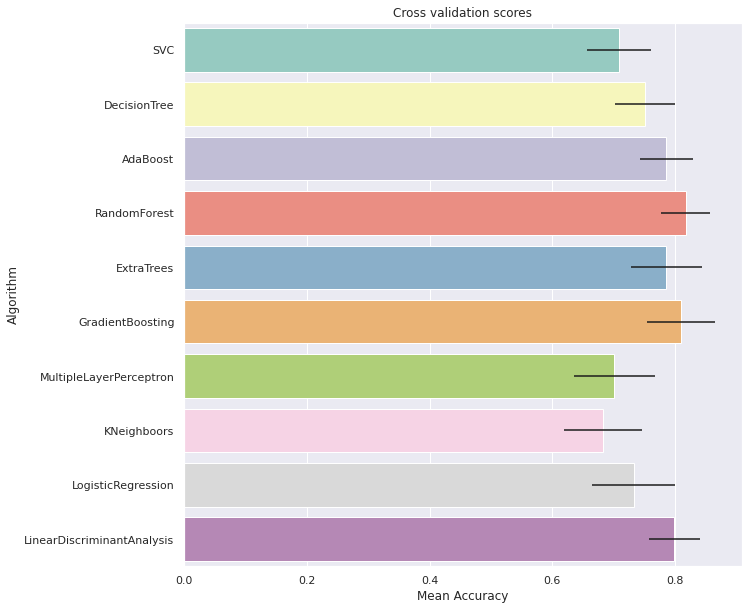

In [75]:
classifiers=[]
random_state=2

classifiers.append(SVC(random_state=2))
classifiers.append(DecisionTreeClassifier(random_state=2))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=1))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [76]:
from xgboost import XGBClassifier

classifier=XGBClassifier(learning_rate=0.02, n_estimators=2000, objective='binary:logistic',
                    silent=True, nthread=6, tree_method='gpu_hist', eval_metric='auc')

xgb_param={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.02, 0.05]    
        }

rsearchcv=RandomizedSearchCV(classifier, param_distributions=xgb_param, cv=kfold, scoring='accuracy', verbose=1)

rsearchcv.fit(X_train,Y_train)

xgb_best = rsearchcv.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[08:57:32] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:34] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:35] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:36] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:37] WARNING: ..

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished


[08:59:36] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [77]:
rsearchcv.best_score_

0.8356902356902356

In [78]:
xgb_best.fit(X_train, Y_train)

[08:59:37] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=1.5, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, silent=True, subsample=1.0,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [79]:
Y_pred=xgb_best.predict(X_test)

In [80]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        94
           1       0.88      0.71      0.79        42

    accuracy                           0.88       136
   macro avg       0.88      0.84      0.85       136
weighted avg       0.88      0.88      0.88       136



In [81]:
confusion_matrix(Y_test, Y_pred)

array([[90,  4],
       [12, 30]])

In [82]:
test["Gender"]=test["Sex"].map({"male": 0, "female": 1})
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [83]:
test["Embarked"]=test["Embarked"].fillna("S")

In [84]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

test["Title"]=test["Name"].apply(get_title)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,Mrs


In [85]:
test["Word_Count"]=test["Name"].apply(lambda x: len(str(x).split()))
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Mr,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,Mrs,5
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Mr,4
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,Mr,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,Mrs,6


In [86]:
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Mr,3,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,Mrs,5,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Mr,4,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,Mr,3,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,Mrs,6,0


In [87]:
test["Name_Size"]=test["Name"].apply(lambda x: len(x))
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Mr,3,0,16
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,Mrs,5,0,32
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Mr,4,0,25
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,Mr,3,0,16
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,Mrs,6,0,44


In [88]:
test["Embarked"]=test["Embarked"].map({"S": 0, "C": 1, "Q": 2})
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,2,0,Mr,3,0,16
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,0,1,Mrs,5,0,32
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,2,0,Mr,4,0,25
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,0,0,Mr,3,0,16
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,0,1,Mrs,6,0,44


In [89]:
test["Ticket_Word"]=test["Ticket"].apply(lambda x: len(str(x).split()))
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,2,0,Mr,3,0,16,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,0,1,Mrs,5,0,32,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,2,0,Mr,4,0,25,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,0,0,Mr,3,0,16,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,0,1,Mrs,6,0,44,1


In [90]:
test["Ticket_Len"]=test["Ticket"].apply(lambda x: len(x))
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,2,0,Mr,3,0,16,1,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,0,1,Mrs,5,0,32,1,6
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,2,0,Mr,4,0,25,1,6
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,0,0,Mr,3,0,16,1,6
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,0,1,Mrs,6,0,44,1,7


In [91]:
test["Cabin"]=test["Cabin"].fillna("Na")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,2,0,Mr,3,0,16,1,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,0,1,Mrs,5,0,32,1,6
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,2,0,Mr,4,0,25,1,6
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,0,0,Mr,3,0,16,1,6
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,0,1,Mrs,6,0,44,1,7


In [92]:
test["Title"].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

In [93]:
test["Age"]=test["Age"].fillna(X_train["Age"].median())

In [94]:
test["Title"]=test["Title"].map({"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4, "Dr": 5, "Rev": 6})
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,2,0,0.0,3,0,16,1,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,0,1,2.0,5,0,32,1,6
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,2,0,0.0,4,0,25,1,6
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,0,0,0.0,3,0,16,1,6
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,0,1,2.0,6,0,44,1,7


In [95]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
Gender         0
Title          4
Word_Count     0
Has_Cabin      0
Name_Size      0
Ticket_Word    0
Ticket_Len     0
dtype: int64

In [96]:
test["Fare"]=test["Fare"].fillna(X_train["Fare"].median())

In [97]:
def cabin_list(cabin_str):
    l=str(cabin_str).split()
    return l
test["Cabin_List"]=test["Cabin"].apply(cabin_list)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_List
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,2,0,0.0,3,0,16,1,6,[Na]
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,0,1,2.0,5,0,32,1,6,[Na]
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,2,0,0.0,4,0,25,1,6,[Na]
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,0,0,0.0,3,0,16,1,6,[Na]
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,0,1,2.0,6,0,44,1,7,[Na]


In [98]:
def num_cabin(cabin_list):
    return len(cabin_list)
test["Cabin_Size"]=test["Cabin_List"].apply(num_cabin)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_List,Cabin_Size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,2,0,0.0,3,0,16,1,6,[Na],1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,0,1,2.0,5,0,32,1,6,[Na],1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,2,0,0.0,4,0,25,1,6,[Na],1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,0,0,0.0,3,0,16,1,6,[Na],1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,0,1,2.0,6,0,44,1,7,[Na],1


In [99]:
test["Family_Count"]=test["SibSp"]+test["Parch"]+1
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_List,Cabin_Size,Family_Count
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,...,0,0.0,3,0,16,1,6,[Na],1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,...,1,2.0,5,0,32,1,6,[Na],1,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,...,0,0.0,4,0,25,1,6,[Na],1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,...,0,0.0,3,0,16,1,6,[Na],1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,...,1,2.0,6,0,44,1,7,[Na],1,3


In [100]:
test["Is_Alone"]=0
test.loc[test['Family_Count'] == 1, 'Is_Alone'] = 1
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_List,Cabin_Size,Family_Count,Is_Alone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,...,0.0,3,0,16,1,6,[Na],1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,...,2.0,5,0,32,1,6,[Na],1,2,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,...,0.0,4,0,25,1,6,[Na],1,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,...,0.0,3,0,16,1,6,[Na],1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,...,2.0,6,0,44,1,7,[Na],1,3,0


In [101]:
test["Name_Size_Sq"]=test["Name_Size"]**2
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_List,Cabin_Size,Family_Count,Is_Alone,Name_Size_Sq
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,...,3,0,16,1,6,[Na],1,1,1,256
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,...,5,0,32,1,6,[Na],1,2,0,1024
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,...,4,0,25,1,6,[Na],1,1,1,625
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,...,3,0,16,1,6,[Na],1,1,1,256
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,...,6,0,44,1,7,[Na],1,3,0,1936


In [102]:
test["Word_Count_Sq"]=test["Word_Count"]**2
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_List,Cabin_Size,Family_Count,Is_Alone,Name_Size_Sq,Word_Count_Sq
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,...,0,16,1,6,[Na],1,1,1,256,9
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,...,0,32,1,6,[Na],1,2,0,1024,25
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,...,0,25,1,6,[Na],1,1,1,625,16
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,...,0,16,1,6,[Na],1,1,1,256,9
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,...,0,44,1,7,[Na],1,3,0,1936,36


In [103]:
test["Is_Alone"]=test["Is_Alone"].fillna(0)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_List,Cabin_Size,Family_Count,Is_Alone,Name_Size_Sq,Word_Count_Sq
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Na,...,0,16,1,6,[Na],1,1,1,256,9
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Na,...,0,32,1,6,[Na],1,2,0,1024,25
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Na,...,0,25,1,6,[Na],1,1,1,625,16
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Na,...,0,16,1,6,[Na],1,1,1,256,9
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Na,...,0,44,1,7,[Na],1,3,0,1936,36


In [104]:
test.drop(["Sex", "Ticket", "Name", "Cabin","Cabin", "Cabin_List"], axis=1, inplace=True)
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_Size,Family_Count,Is_Alone,Name_Size_Sq,Word_Count_Sq
0,892,3,34.5,0,0,7.8292,2,0,0.0,3,0,16,1,6,1,1,1,256,9
1,893,3,47.0,1,0,7.0000,0,1,2.0,5,0,32,1,6,1,2,0,1024,25
2,894,2,62.0,0,0,9.6875,2,0,0.0,4,0,25,1,6,1,1,1,625,16
3,895,3,27.0,0,0,8.6625,0,0,0.0,3,0,16,1,6,1,1,1,256,9
4,896,3,22.0,1,1,12.2875,0,1,2.0,6,0,44,1,7,1,3,0,1936,36


In [105]:
X_pred=test.drop(["PassengerId"], axis=1)
X_pred.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender,Title,Word_Count,Has_Cabin,Name_Size,Ticket_Word,Ticket_Len,Cabin_Size,Family_Count,Is_Alone,Name_Size_Sq,Word_Count_Sq
0,3,34.5,0,0,7.8292,2,0,0.0,3,0,16,1,6,1,1,1,256,9
1,3,47.0,1,0,7.0000,0,1,2.0,5,0,32,1,6,1,2,0,1024,25
2,2,62.0,0,0,9.6875,2,0,0.0,4,0,25,1,6,1,1,1,625,16
3,3,27.0,0,0,8.6625,0,0,0.0,3,0,16,1,6,1,1,1,256,9
4,3,22.0,1,1,12.2875,0,1,2.0,6,0,44,1,7,1,3,0,1936,36


In [106]:
X_pred=X_pred.reindex(columns=X.columns)
X_pred.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Name_Size,Word_Count,Has_Cabin,Family_Count,Title,Is_Alone,Ticket_Len,Ticket_Word,Fare_Sq,Word_Count_Sq,Name_Size_Sq,Cabin_Size,Gender
0,3,34.5,0,0,7.8292,2,16,3,0,1,0.0,1,6,1,NaN,9,256,1,0
1,3,47.0,1,0,7.0000,0,32,5,0,2,2.0,0,6,1,NaN,25,1024,1,1
2,2,62.0,0,0,9.6875,2,25,4,0,1,0.0,1,6,1,NaN,16,625,1,0
3,3,27.0,0,0,8.6625,0,16,3,0,1,0.0,1,6,1,NaN,9,256,1,0
4,3,22.0,1,1,12.2875,0,44,6,0,3,2.0,0,7,1,NaN,36,1936,1,1


In [107]:
pred=xgb_best.predict(X_pred)
o={'PassengerId': test['PassengerId'], 'Survived': pred}
out=pd.DataFrame(o, columns=['PassengerId', 'Survived'])
out.to_csv('submission.csv', index=False, header=True)
out.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
